In [23]:
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
import matplotlib.pyplot as plt

In [15]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    return policy, V

In [85]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[20,20]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape) #state
        nA = 4 #action

        MAX_Y = shape[0]
        MAX_X = shape[1]

        map_matrix = np.load('lab11_map_matrix.npy')
        start_s = [] #start point
        target_s = [] #target point
        obstacle_s= [] #obstacle point
        for x in range(map_matrix.shape[0]):
            for y in range(map_matrix.shape[1]):
                if (map_matrix[x,y]==np.array([255,0,0])).all(): #red
                    target_s.append(x*20+y)
                elif (map_matrix[x,y]==np.array([255,255,255])).all():#white
                    start_s.append(x*20+y)
                elif (map_matrix[x,y]==np.array([0,30,0])).all():#green
                    obstacle_s.append(x*20+y)
                else:
                    continue
        #reward_matrix = np.load('lab11_reward_matrix.npy')#reward
        
        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: 1 if s in target_s else 0
            #is_done = lambda s: s==0 or s==nS-1
            if is_done(s):
                reward =0.0
            elif s in obstacle_s:
                reward = -2.0
            else:
                reward = -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1, s, reward, True)]
                P[s][RIGHT] = [(1, s, reward, True)]
                P[s][DOWN] = [(1, s, reward, True)]
                P[s][LEFT] = [(1, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P
        
        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip() 
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 2 1 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(2,3)
(3,3)
(3,4)
(3,5)
(3,6)
(3,7)
(3,8)
(3,9)
(3,10)
(3,11)
(3,12)
(3,13)
(3,14)
(4

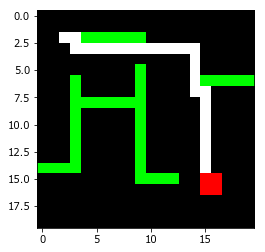

In [106]:
env = GridworldEnv()
policy, v = value_iteration(env)
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
policy_matrix = np.reshape(np.argmax(policy, axis=1), env.shape)
print(policy_matrix)
#print("Reshaped Grid Value Function:")
#print(v.reshape(env.shape))
map_matrix = np.load('lab11_map_matrix.npy') #first state
#map_matrix[2,2,:]=255 #white start
x =2
y =2
#while not (map_matrix[x,y]==np.array([255,0,0])).all():
while True:
    next_pos =  policy_matrix[x][y]
    if next_pos == 0: x=x-1
    elif next_pos == 1 : y=y+1
    elif next_pos == 2 : x= x+1
    elif next_pos == 3: y=y-1
    else: print ('error')
    print ('({},{})'.format(x,y))
    if (map_matrix[x,y]==np.array([255,0,0])).all():
        break
    map_matrix[x,y,:]=255 #trail
plt.imshow(map_matrix)
plt.show()

In [62]:
map_matrix = np.load('lab11_map_matrix.npy') #first state
start_s = [] #start point
target_s = [] #target point
obstacle_s= [] #obstacle point
for x in range(map_matrix.shape[0]):
    for y in range(map_matrix.shape[1]):
        if (map_matrix[x,y]==np.array([255,0,0])).all(): #red
            target_s.append(x*20+y)
        elif (map_matrix[x,y]==np.array([255,255,255])).all():#white
            start_s.append(x*20+y)
        elif (map_matrix[x,y]==np.array([0,30,0])).all():#green
            obstacle_s.append(x*20+y)
        else:
            continue
print (start_s)
print (target_s)
print (obstacle_s)

[42]
[315, 316, 335, 336]
[44, 45, 46, 47, 48, 49, 109, 123, 129, 135, 136, 137, 138, 139, 143, 149, 163, 164, 165, 166, 167, 168, 169, 183, 189, 203, 209, 223, 229, 243, 249, 263, 269, 280, 281, 282, 283, 289, 309, 310, 311, 312]


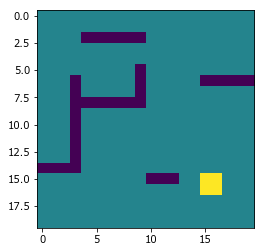

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


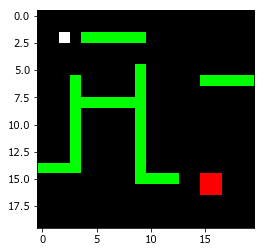

In [59]:
reward_matrix = np.load('lab11_reward_matrix.npy')#reward
plt.imshow(reward_matrix)
plt.show()
map_matrix = np.load('lab11_map_matrix.npy') #first state
plt.imshow(map_matrix)
plt.show()